In [101]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, timedelta, datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss
from sklearn.linear_model import QuantileRegressor
from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.layers import Input, Conv1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.losses import pinball_loss

In [102]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [1,2,3,4,5]

# Get data

In [103]:
current_day = datetime.today()
data = yf.download("^GDAXI", start="2000-01-01", end=current_day)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


# Get baseline

In [104]:
def get_baseline(date, days = 1500, data = data):
    date = date - timedelta(days)
    baseline_results = pd.DataFrame(columns = np.arange(1,6), index = quantiles)
    filtered_data = data[data.index > date]

    for step in np.arange(1,6):

        step_log_return = 100 * (np.log(filtered_data) - np.log(filtered_data.shift(step)))
        step_log_return.dropna(inplace = True)

        #Calculate quantiles
        baseline_quantiles = np.quantile(last_evaluation, quantiles)
        baseline_results.loc[:,step]=baseline_quantiles
    return baseline_results

In [105]:
#get_baseline(current_day)

# Wavenet modeling

## Data preparation

Add all five horizons as a predictor

In [106]:
data_prep = pd.DataFrame(data)
data_prep["log_return"] = 100 * (np.log(data_prep) - np.log(data_prep.shift(1)))
for horizon in range(1,6):
    data_prep[horizon] = 100 * (np.log(data_prep["Adj Close"]) - np.log(data_prep["Adj Close"].shift(horizon)))
    data_prep[horizon] = data_prep[horizon].shift(-horizon)

#Drop CLose
data_prep.drop("Adj Close", axis = 1, inplace = True)

In [107]:
data_prep.head()

,log_return,1,2,3,4,5
Date,,,,,,
2000-01-03,NaN,-2.456461,-3.753450,-4.171882,0.446362,2.555809
2000-01-04,-2.456461,-1.296989,-1.715421,2.902823,5.012269,4.516204
2000-01-05,-1.296989,-0.418432,4.199812,6.309258,5.813193,6.125566
2000-01-06,-0.418432,4.618244,6.727690,6.231625,6.543998,7.166548
2000-01-07,4.618244,2.109446,1.613381,1.925754,2.548304,5.623600


### Create test, val, train and prediction data

Total length of data is 5530:
- Will take half a year - 180 as a test set
- Whole year as validation set
- Rest as training set

In [108]:
window_size = 128
max_horizon = 5
test_size = 360
val_size = 360

pred_data = data_prep[-128:]

#Drop Nans
data_prep.dropna(inplace = True)

test_data = data_prep[-test_size:]
val_data = data_prep[-val_size-test_size:-test_size]
train_data = data_prep[:-val_size-test_size]

### Normalize data

In [109]:
train_mean = train_data.mean()
train_sd = train_data.std()

In [110]:
def normalize(data, mean = train_mean, sd = train_sd):
    return (data-mean)/sd

In [111]:
train_data = normalize(train_data)
val_data = normalize(val_data)
test_data = normalize(test_data)
pred_data = normalize(pred_data)

### Apply rolling window and get predictor

In [112]:
def convert_data(data, horizon = 1, window_size = window_size):
    data_numpy = np.array(data)
    window = sliding_window_view(data_numpy,window_size, axis = 0)
    window = np.swapaxes(window, 1,2)
    X = window[:,:,0:1]
    Y = window[:,:,horizon:horizon+1]
    return (X,Y)

In [113]:
x_train, y_train = convert_data(train_data, horizon = 5)
x_val, y_val = convert_data(val_data)

## Build model

In [114]:
def model(trainX, trainY, dropout_rate = 0.1):
    """
    trainX -- input values; shape: [number of samples, NUM_UNROLLINGS, 1]
    trainY -- output values (inputs shifted by 1); shape: [number of samples, NUM_UNROLLINGS, 1]
    """

    filters = 8
    kernel_size = 2
    input_ts = Input(shape=(trainX.shape[1], 1))
    #Base layers
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=1)(input_ts)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=2)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=4)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=8)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=16)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=32)(x)
    #Fully Layer
    out = Conv1D(32, 1, padding = "same")(x)
    out = Dropout(dropout_rate)(out)
    out = Conv1D(1, 1, activation="linear")(out)
    cnn = Model(input_ts, out)
    return cnn

### Define parameters

In [115]:
BATCH_SIZE = 128
EPOCHS = 500
quantile = quantiles[0]
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adadelta(learning_rate = learning_rate)

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta = 1e-5)

## Training process

In [116]:
cnn = model(x_train, y_train)

In [117]:
def train_model(model, optimizer, x_train, y_train, x_val, y_val, quantile, BATCH_SIZE = BATCH_SIZE, EPOCHS = EPOCHS, callback = callback):
    model.compile(optimizer = optimizer,  loss = lambda true,pred: pinball_loss(true, pred, tau = quantile))
    history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = EPOCHS,batch_size = BATCH_SIZE, shuffle=True,
        callbacks = [callback], verbose = False)
    return model

In [ ]:
cnn.summary()

## Predict test data

In [118]:
## Returns output of shape [samples, enrollings, horizon, quantile]
def train_and_predict(train_data = train_data, val_data = val_data, test_data = test_data, pred_data = pred_data, quantiles = quantiles, horizons = horizons):

    test_pred = np.zeros((test_size-window_size+1, window_size, len(horizons), len(quantiles)))
    future_pred = np.zeros((len(horizons), len(quantiles)))

    for horizon in horizons:
        #Get data
        x_train, y_train = convert_data(train_data, horizon = horizon)
        x_val, y_val = convert_data(val_data, horizon = horizon)
        x_test, y_test = convert_data(test_data, horizon = horizon)
        x_pred, _ = convert_data(pred_data, horizon = horizon)
        for cnt, quantile in enumerate(quantiles):           
            cnn = model(x_train, y_train)
            cnn = train_model(cnn, optimizer, x_train, y_train, x_val, y_val, quantile)

            horizon_pred = cnn.predict(x_test)
            test_pred[:,:,horizon-1,cnt] = horizon_pred[:,:,0]

            #Future pred
            future_pred[horizon-1,cnt] = cnn.predict(x_pred)[0,-1,0]
            
            #Print checkpoint
            print("Finished horizon_{}, quantile_{}".format(horizon,quantile))
    
    #Return predictions
    return (test_pred, future_pred)

In [119]:
test_pred, future_pred = train_and_predict()

Finished horizon_1, quantile_0.025
Finished horizon_1, quantile_0.25
Finished horizon_1, quantile_0.5
Finished horizon_1, quantile_0.75
Finished horizon_1, quantile_0.975
Finished horizon_2, quantile_0.025
Finished horizon_2, quantile_0.25
Finished horizon_2, quantile_0.5
Finished horizon_2, quantile_0.75
Finished horizon_2, quantile_0.975
Finished horizon_3, quantile_0.025
Finished horizon_3, quantile_0.25
Finished horizon_3, quantile_0.5
Finished horizon_3, quantile_0.75
Finished horizon_3, quantile_0.975
Finished horizon_4, quantile_0.025
Finished horizon_4, quantile_0.25
Finished horizon_4, quantile_0.5
Finished horizon_4, quantile_0.75
Finished horizon_4, quantile_0.975
Finished horizon_5, quantile_0.025
Finished horizon_5, quantile_0.25
Finished horizon_5, quantile_0.5
Finished horizon_5, quantile_0.75
Finished horizon_5, quantile_0.975


## Analyze results

In [120]:
def convert_result(data, length = len(test_data)):
    results_array = np.zeros((length,5))
    for cnt, sample in enumerate(data):
        if cnt == 0 :
            results_array[0:window_size] = sample[0:window_size]
        else :
            results_array[window_size+cnt-1] = sample[window_size-1]
    return results_array

In [121]:
test_pred.shape

(233, 128, 5, 5)

In [122]:
x_test, y_test = convert_data(test_data, horizon = horizon)
##Prepare Loss matrix
losses = pd.DataFrame(index = quantiles, columns = horizons)
true_transformed = convert_result(x_test, length = len(test_data))
for cnt, quantile in enumerate(quantiles):
    for horizon in horizons:
        pred = test_pred[:,:,horizon-1,cnt:cnt+1]
        pred_transformed = convert_result(pred, length = len(test_data))
        loss = tf.reduce_mean(pinball_loss(true_transformed[:,horizon-1], pred_transformed[:,horizon-1], tau = quantile))
        losses.loc[quantile, horizon] = loss.numpy()

In [123]:
losses

,1,2,3,4,5
0.025,0.050451,0.06894,0.049217,0.048451,0.046026
0.250,0.23331,0.242311,0.234073,0.236377,0.236192
0.500,0.279868,0.279905,0.28056,0.279223,0.280332
0.750,0.244985,0.248608,0.24647,0.246037,0.248767
0.975,0.071906,0.0714,0.05578,0.060683,0.06654


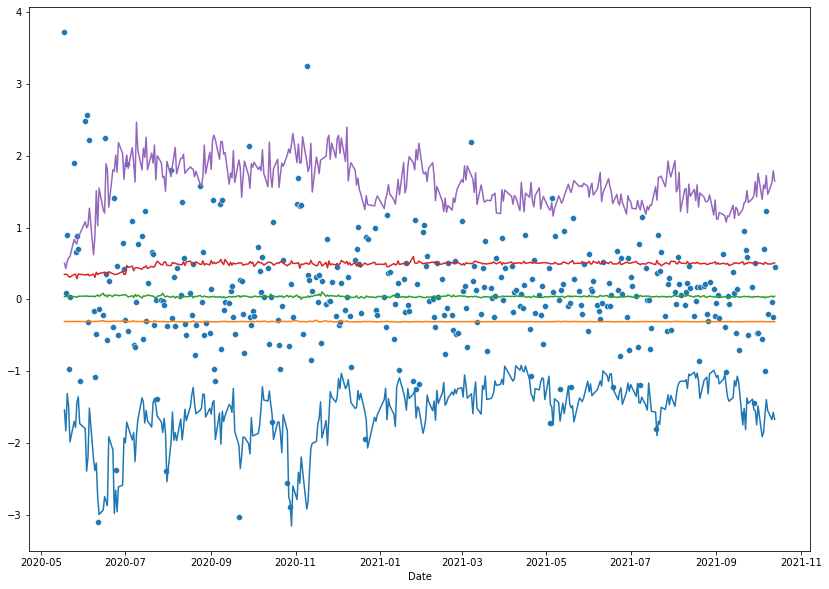

In [139]:
h = 1
fig, ax = plt.subplots(figsize=(14,10))
true_transformed = convert_result(x_test, length = len(test_data))
sns.scatterplot(x = test_data.index, y = true_transformed[:,h-1])
for cnt,quantile in enumerate(quantiles):
    pred = test_pred[:,:,h-1,cnt:cnt+1]
    pred_transformed = convert_result(pred, length = len(test_data))
    sns.lineplot(x = test_data.index, y = pred_transformed[:,h-1])

### Test plausability of model

In [140]:
true_transformed = convert_result(x_test, length = len(test_data))
for cnt, quantile in enumerate(quantiles):
    pred = test_pred[:,:,h-1,cnt:cnt+1]
    pred_transformed = convert_result(pred, length = len(test_data))
    q_smaller = (pred_transformed[:,h-1] > true_transformed[:,h-1]).sum()
    emp_quant = q_smaller / pred_transformed[:,h-1].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 2.5 %
Quantile met for quantile = 0.25: 	 25.0 %
Quantile met for quantile = 0.5: 	 49.72 %
Quantile met for quantile = 0.75: 	 76.11 %
Quantile met for quantile = 0.975: 	 96.39 %


## Prepare predicted data

### Renormalize data

In [141]:
for i in range(5):
    future_pred[i,:] = future_pred[i,:]*train_sd[i+1] + train_mean[i+1]

In [142]:
df_horizons = [1,2,5,6,7]
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"])
final_prediction["forecast_date"] = [(current_day).strftime("%Y-%m-%d") for x in df_horizons]
final_prediction["horizon"] = ["{} day".format(x) for x in df_horizons]
final_prediction["target"] = "DAX"

for cnt, quantile in enumerate(quantiles):
    final_prediction["q{}".format(quantile)] = future_pred[:,cnt]

In [143]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2021-10-20,DAX,1 day,-2.739411,-0.650267,0.114251,1.129395,3.340193
1,2021-10-20,DAX,2 day,-9.585247,-2.174104,0.343736,2.347618,7.745867
2,2021-10-20,DAX,5 day,-9.802836,-2.073265,0.630373,3.970054,5.013111
3,2021-10-20,DAX,6 day,-12.600079,-3.400104,0.881958,4.590085,9.053760
4,2021-10-20,DAX,7 day,-15.115002,-4.352365,1.174757,6.159860,17.666272


## Save final prediction

In [149]:
current_date = date.today().strftime("%Y-%m-%d")
final_prediction.to_pickle("../evaluation/predictions/single/DAX_{}".format(current_date))